# Data Loading: TensorFlow TFRecord

## Overview

This example shows you how to use the data that is stored in the TensorFlow TFRecord format with DALI.

## Creating index

To use data that is stored in the TFRecord format, we need to use the `TFRecordReader` operator. In addition to the arguments that are common to all readers, such as `random_shuffle`, this operator takes `path`, `index_path` and `features` arguments.

* `path` is a list of paths to the TFRecord files
* `index_path` is a list that contains the paths to index files, which are used by DALI mainly to properly shard the dataset between multiple workers. The index for a TFRecord file can be obtained from that file by using the `tfrecord2idx` utility that is included with DALI. You need to create the index file only once per TFRecord file.
* `features` is a dictionary of pairs (name, feature), where feature (of type `dali.tfrecord.Feature`) describes the contents of the TFRecord. DALI features closely follow the TensorFlow types `tf.FixedLenFeature` and `tf.VarLenFeature`.

The `DALI_EXTRA_PATH` environment variable should point to the location where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded.

**Important**: Ensure that you check out the correct release tag that corresponds to installed DALI version.

In [1]:
from subprocess import call
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
tfrecord = os.path.join(test_data_root, 'db', 'tfrecord', 'train')
batch_size = 16
tfrecord_idx = "idx_files/train.idx"
tfrecord2idx_script = "tfrecord2idx"

if not os.path.exists("idx_files"):
    os.mkdir("idx_files")

if not os.path.isfile(tfrecord_idx):
    call([tfrecord2idx_script, tfrecord, tfrecord_idx])

## Defining and Running the Pipeline

1. Define a simple pipeline that takes the images stored in TFRecord format, decodes them, and prepares them for ingestion in DL framework.

   Processing images involves cropping, normalizing, and `HWC` -> `CHW` conversion process.

The TFRecord file that we used in this example does not have images upscaled to a common size. This results in an error during cropping, when the image is smaller than the crop window. To overcome this issue, use the `Resize` operation before you crop. This step ensures that the shorter side of images being cropped is 256 pixels.

In [2]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import numpy as np

pipe = Pipeline(batch_size=batch_size, num_threads=4, device_id=0)
with pipe:
    inputs = fn.tfrecord_reader(
        path=tfrecord, 
        index_path=tfrecord_idx,
        features={
            "image/encoded" : tfrec.FixedLenFeature((), tfrec.string, ""),
            "image/class/label": tfrec.FixedLenFeature([1], tfrec.int64,  -1),
            "image/class/text": tfrec.FixedLenFeature([ ], tfrec.string, ""),
            "image/object/bbox/xmin": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/ymin": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/xmax": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/ymax": tfrec.VarLenFeature(tfrec.float32, 0.0)})
    jpegs = inputs["image/encoded"]
    images = fn.image_decoder(jpegs, device="mixed", output_type=types.RGB)
    resized = fn.resize(images, device="gpu", resize_shorter=256.)
    output = fn.crop_mirror_normalize(
        resized,
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[0., 0., 0.],
        std=[1., 1., 1.])
    pipe.set_outputs(output, inputs["image/class/text"])


2. Build and run our the pipeline:

In [3]:
pipe.build()
pipe_out = pipe.run()

3. To visualize the results, use the `matplotlib` library, which expects images in `HWC` format, but the output of the pipeline is in `CHW`.

   **Note**: `CHW` is the preferred format for most Deep Learning frameworks.
   
4. For the visualization purposes, transpose the images back to the `HWC` layout.

In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, labels):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii = labels.at(j)
        plt.title("".join([chr(item) for item in ascii]))
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

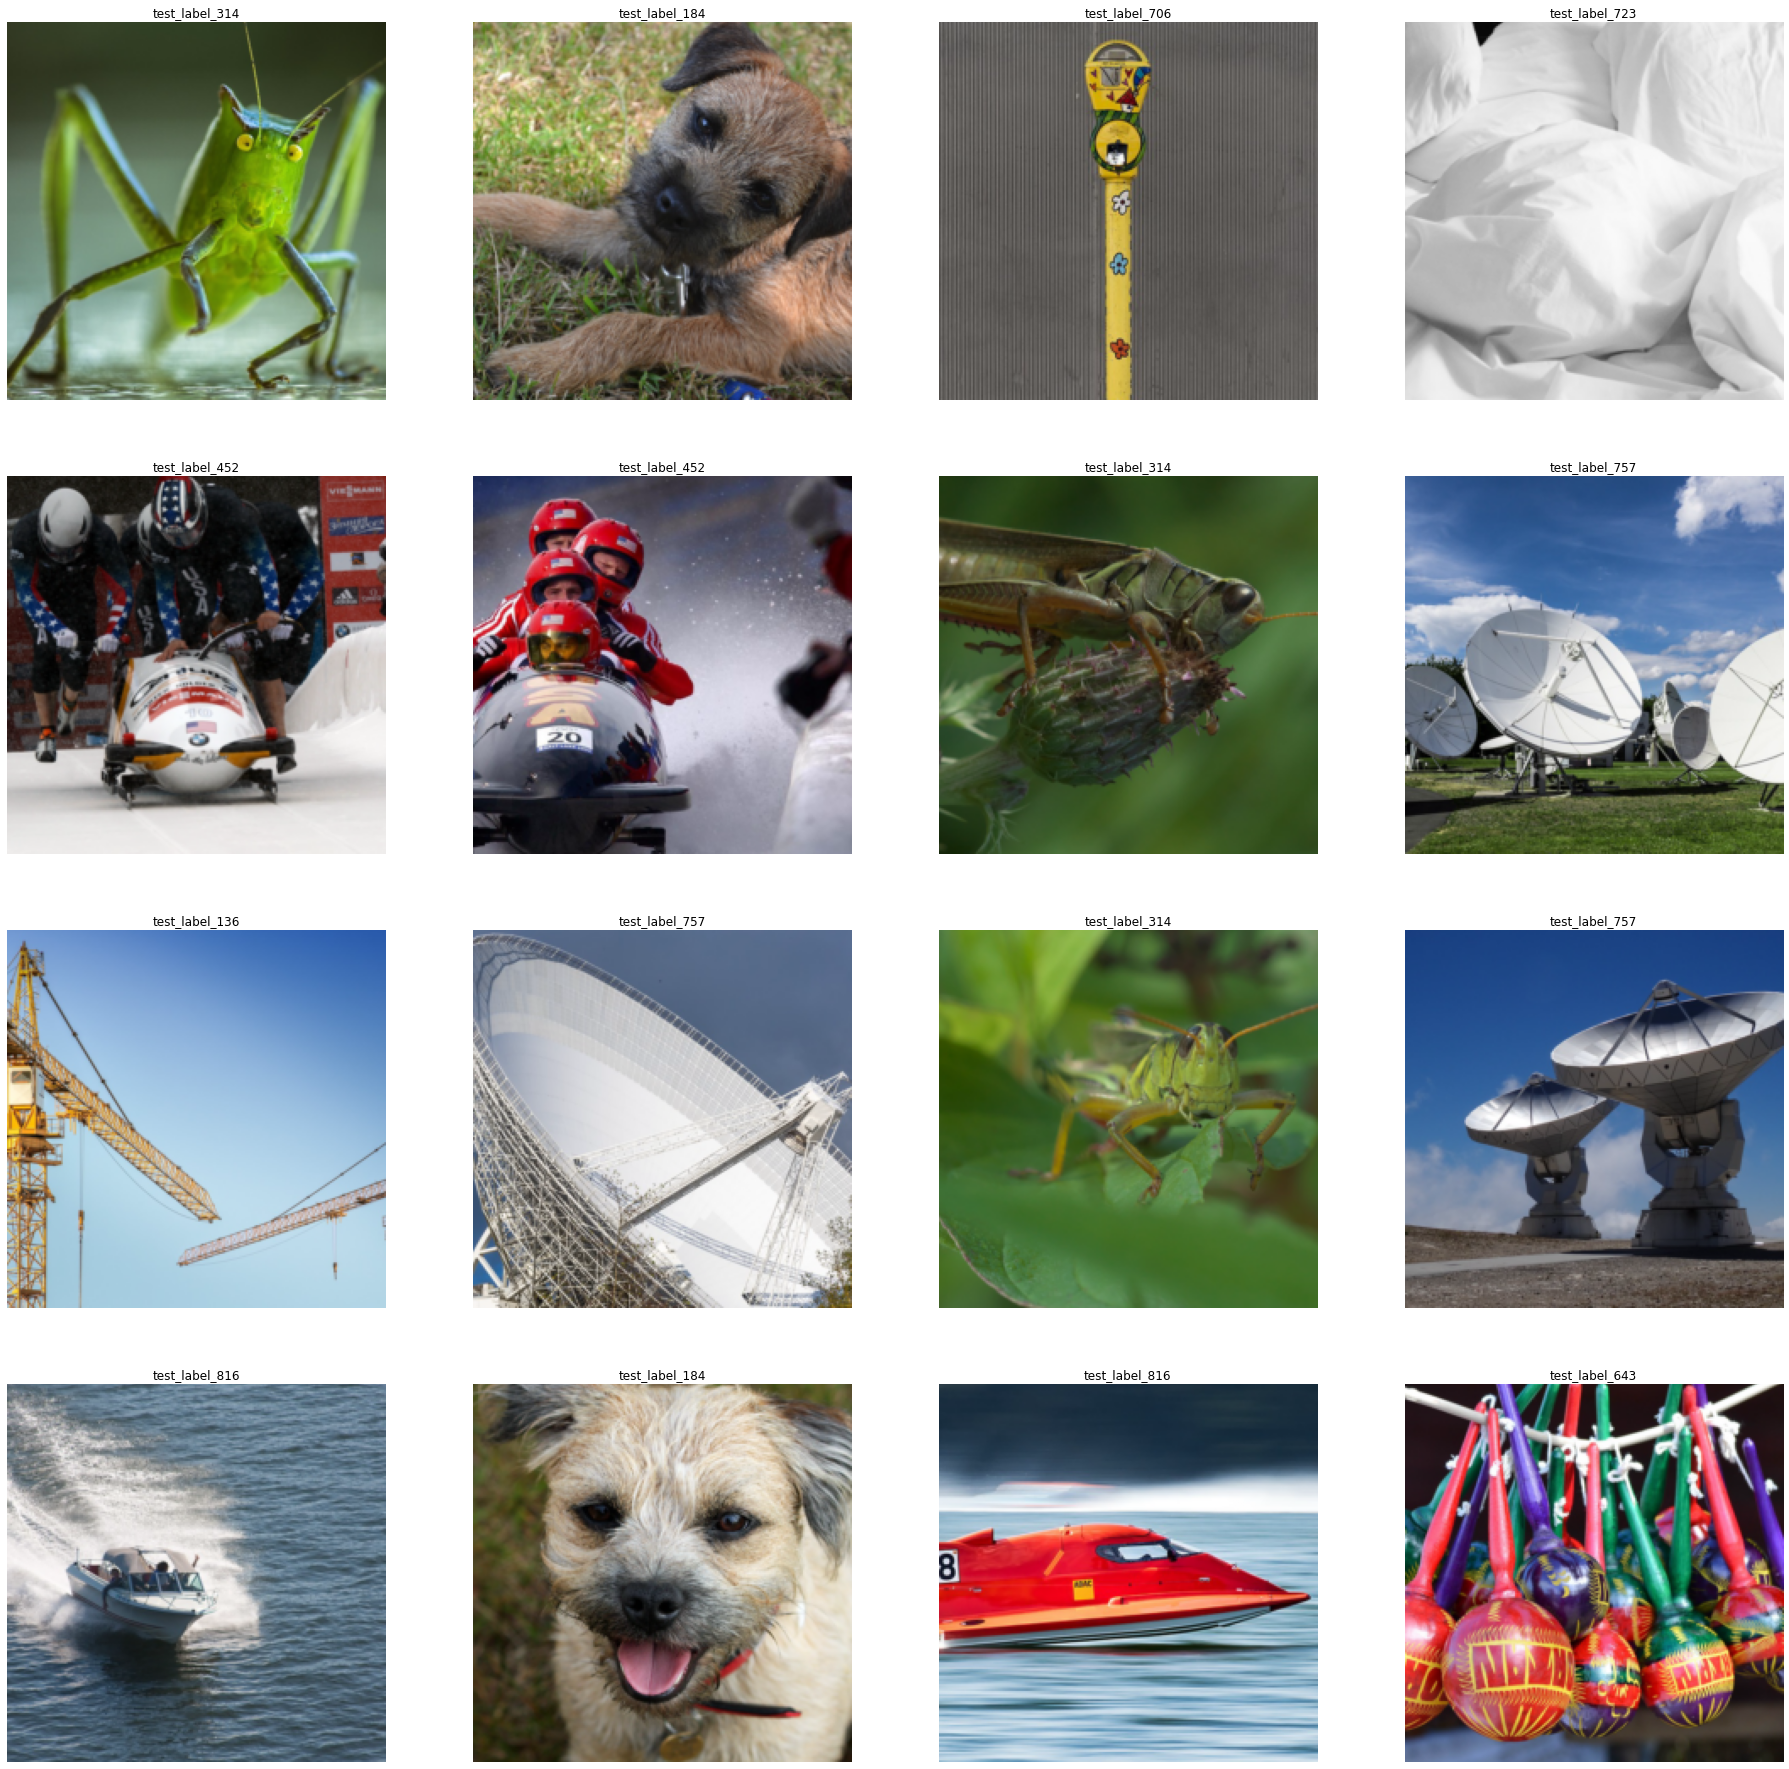

In [5]:
images, labels = pipe_out
show_images(images.as_cpu(), labels)

For more flexibility `VarLenFeature` supports the `partial_shape` parameter. If provided, the data will be reshaped to match its value. The first dimension will be inferred from the data size.